In [1]:
import lightkurve as lk
import astropy.table as astab
import pandas as pd
import astropy
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from tqdm import tqdm
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)
import warnings

warnings.filterwarnings("ignore",message='ERROR:lightkurve.search')
# warnings.filterwarnings('ignore', message=f'No data found for target')
print(astropy.__version__)

import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
import exoplanet as xo

import arviz as az
from corner import corner



dd = "/Users/kjaehnig/CCA_work/GAT/"

Populating the interactive namespace from numpy and matplotlib
4.3.1


In [2]:
calibverr = astab.Table.read(dd+'dr17_joker/allVisit-dr17-synspec-calib-verr.fits', format='fits', hdu=1)
print(calibverr.info)

<Table length=2318773>
   name     dtype 
---------- -------
  VISIT_ID bytes64
CALIB_VERR float64



##### load in apogee visit data for TIC 99254945 

In [3]:
sysapodat = astab.Table.read(dd+'dr17_joker/tic_beatdrop_system_apogee_dat.fits',format='fits',hdu=1)
print(len(sysapodat))
sysapodat = astab.join(sysapodat, calibverr, keys=('VISIT_ID','VISIT_ID'))
print(len(sysapodat))

6
6


##### load in apogee visit data for TIC 20215452 (has more visits in RV for easier fitting)

In [4]:
# sysapodat2 = astab.Table.read(dd+"dr17_joker/tic20215452_apogee_visit_data.fits", hdu=1, format='fits')

<ErrorbarContainer object of 3 artists>

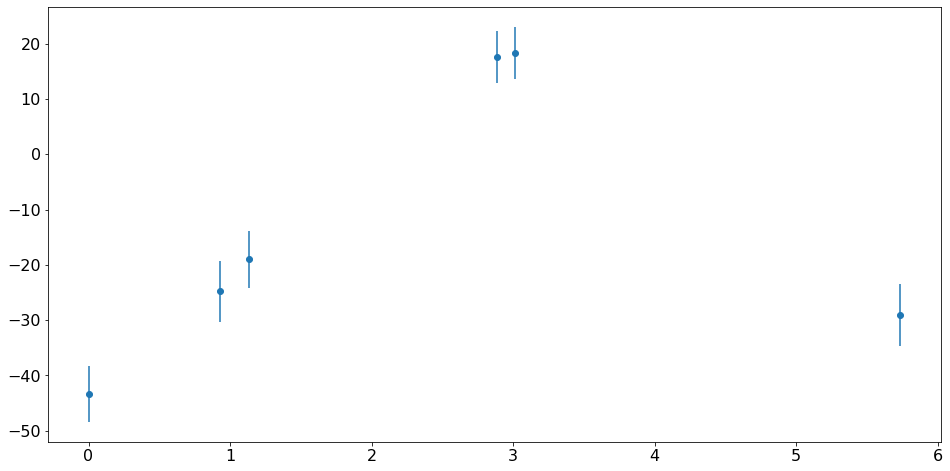

In [59]:
fig,ax = plt.subplots()
ax.errorbar((sysapodat['JD']-sysapodat['JD'].min())%7.7, sysapodat['VHELIO'],yerr=sysapodat['CALIB_VERR']*100,fmt='o')


## straight up ctrl-c, ctrl-v from the exoplanet docs website: 
https://docs.exoplanet.codes/en/latest/tutorials/intro-to-pymc3/#a-more-realistic-example-radial-velocity-exoplanets

In [67]:
MAP_P,MAP_P_err = 7.7, _ 

rv = sysapodat['VHELIO']
rv_err = sysapodat['CALIB_VERR']
t = sysapodat['JD'].astype("float")
t -= np.min(t)


rv_amp = 0.5 * (np.max(rv) - np.min(rv))
with pm.Model() as model:

    # Parameters
    logK = pm.Uniform(
        "logK",
        lower=0,
        upper=5*np.log(rv_amp),
        testval=np.log(rv_amp),
    )
#     logK = pm.Normal(
#         "logK",
#         mu=np.log(rv_amp),
#         sd=5,
#         testval=np.log(rv_amp)
#     )


    logP = pm.Normal(
        "logP",mu=np.log(MAP_P), sd=3, testval=np.log(MAP_P) 
     )
#     logP = pm.Uniform(
#             "logP", lower=0, upper=np.log(10), testval=np.log(MAP_P))
    
#     logP = pm.Lognormal(
#         "logP",
#         mu=4.8,
#         sd=2.3,
#         testval = np.log(MAP_P)
#     )
    phi = pm.Uniform("phi", lower=0, upper=2 * np.pi, testval=0.1)
    
#     prephi = pmx.UnitUniform("prephi", testval=0.1)
#     phi = pm.Deterministic('phi', 2.*np.pi*prephi)
    
    
    # Parameterize the eccentricity using:
    #  h = sqrt(e) * sin(w)
    #  k = sqrt(e) * cos(w)
    hk = pmx.UnitDisk("hk", testval=np.array([0.01, 0.01]))
    e = pm.Deterministic("e", hk[0] ** 2 + hk[1] ** 2)
    w = pm.Deterministic("w", tt.arctan2(hk[1], hk[0]))

    rv0 = pm.Normal("rv0", mu=0.0, sd=10.0, testval=0.0)
    
    rvtrend = pm.Normal("rvtrend", mu=0.0, sd=10.0, testval=0.0)

    # Deterministic transformations
    n = 2 * np.pi * tt.exp(-logP)
    P = pm.Deterministic("P", tt.exp(logP))
    K = pm.Deterministic("K", tt.exp(logK))
    cosw = tt.cos(w)
    sinw = tt.sin(w)
    t0 = (phi + w) / n

    # The RV model
    bkg = pm.Deterministic("bkg", rv0 + rvtrend * t / 365.25)
    M = n * t - (phi + w)   #remove arg of peri + w)

    # This is the line that uses the custom Kepler solver
    f = xo.orbits.get_true_anomaly(M, e + tt.zeros_like(M))
    rvmodel = pm.Deterministic(
        "rvmodel", bkg + K * (cosw * (tt.cos(f) + e) - sinw * tt.sin(f))
    )

    
    ## adding in some wiggle room (e.g. jitter) on the RV measurements 
#     log_sigma_rv = pm.Normal(
#         "log_sigma_rv", mu=np.log(np.median(rv_err)), sd=5.
#     )
    
#     err = tt.sqrt(rv_err ** 2 + tt.exp(2 * log_sigma_rv))
    # Condition on the observations
    pm.Normal("obs", mu=rvmodel, sd=rv_err, observed=rv)

    # Compute the phased RV signal
    phase = np.linspace(0, 1, 500)
    M_pred = 2 * np.pi * phase - (phi + w)
    f_pred = xo.orbits.get_true_anomaly(M_pred, e + tt.zeros_like(M_pred))
    rvphase = pm.Deterministic(
        "rvphase", K * (cosw * (tt.cos(f_pred) + e) - sinw * tt.sin(f_pred))
    )

In [68]:
with model:
#     map_params = pmx.optimize(vars=[logK])
    map_params = pmx.optimize(vars=[logK,rvtrend, rv0, hk, phi])
    map_params = pmx.optimize(start=map_params, vars=[logP])


    

optimizing logp for variables: [phi, hk, rv0, rvtrend, logK]


message: Desired error not necessarily achieved due to precision loss.
logp: -2567095.9016693113 -> -1.8239048813734264
optimizing logp for variables: [logP]


message: Optimization terminated successfully.
logp: -1.8239048813734264 -> -1.8238908683379815


KeyError: 'log_sigma_rv'

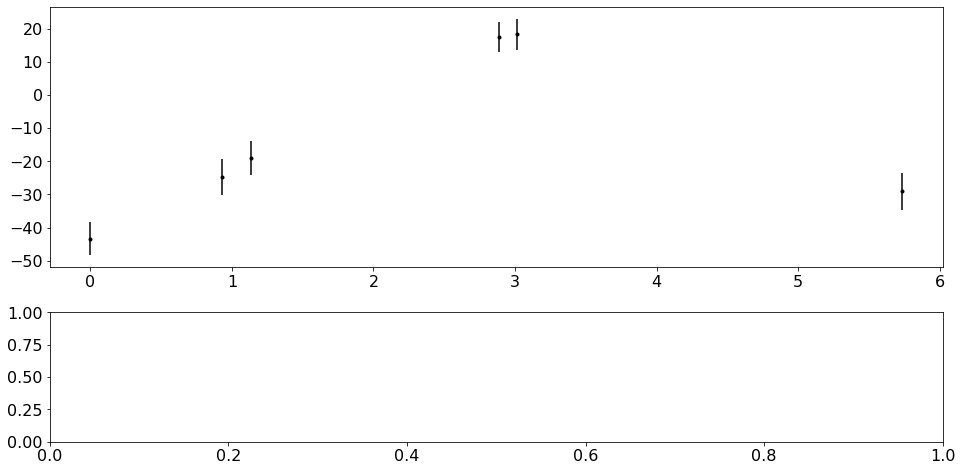

In [69]:
from matplotlib.gridspec import GridSpec
gs1 = GridSpec(nrows=50,ncols=1)
fig = plt.figure()
ax1 = fig.add_subplot(gs1[:30,:])
ax2 = fig.add_subplot(gs1[35:,:])

ax1.errorbar(t%MAP_P, rv, yerr=rv_err*100, fmt=".k",zorder=1, label='100 * calib_verr')
sig_rv_b4_mcmc = np.sqrt(rv_err.value**2 + np.exp(2.*map_params['log_sigma_rv']))


ax1.errorbar(t%MAP_P, rv, yerr=sig_rv_b4_mcmc*100, fmt='.r',zorder=0, label='100 * (calib_verr**2 + sig_rv**2)')


residuals_b4_mcmc = rv - map_params['rvmodel']
print(map_params.keys())
params_b4_mcmc = {ii:map_params[ii] for ii in ['P','K','rvmodel','rvphase','rv0','w','e','phi','log_sigma_rv']}
print(params_b4_mcmc)

ax2.errorbar(t%MAP_P, residuals_b4_mcmc, yerr=rv_err, fmt='.k',label='calib_verr')
ax2.errorbar(t%MAP_P, residuals_b4_mcmc, yerr=sig_rv_b4_mcmc, fmt='.r',zorder=0,label='(calib_verr**2 + sig_rv**2)')
ax2.axhline(0,ls='--')
    
ax1.legend()
ax2.legend(fontsize=16,loc=(0.6,0.5))
rcParams['font.size'] = 16
ax2.set_xlabel("phase (MAP_P ~7.7d)")
ax2.set_ylabel("rv_obs - map_params['rvmodel']")
ax1.set_ylabel("radial velocity")

#### checking the map params optimization results

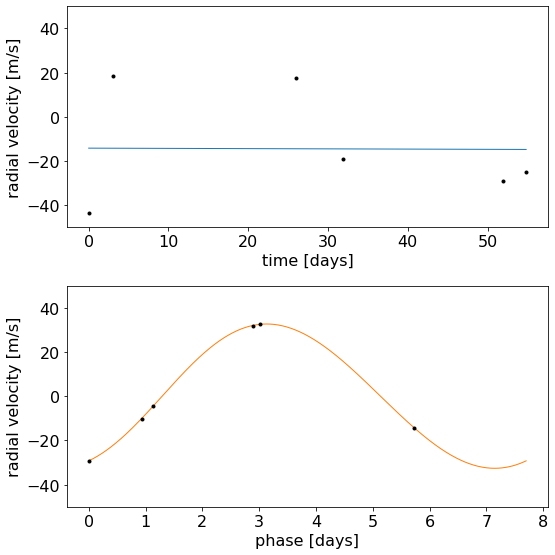

In [70]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

period = map_params["P"]

ax = axes[0]
ax.errorbar(t, rv, yerr=rv_err, fmt=".k")
ax.plot(t, map_params["bkg"], color="C0", lw=1)
ax.set_ylim(-50, 50)
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("time [days]")

ax = axes[1]
ax.errorbar(t % period, rv - map_params["bkg"], yerr=rv_err, fmt=".k")
ax.plot(phase * period, map_params["rvphase"], color="C1", lw=1)
ax.set_ylim(-50, 50)
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("phase [days]")

plt.tight_layout()

## RUN THE PYMC3 MODEL (DO NOT MELT THE RAM)

In [71]:
np.random.seed(42)
with model:
    paramtrace = pmx.sample(
        draws=5000,
        tune=10000,
        start=map_params,
        chains=6,
        cores=6,
        target_accept=0.999,
        return_inferencedata=True,
    )

Multiprocess sampling (6 chains in 6 jobs)
INFO:pymc3:Multiprocess sampling (6 chains in 6 jobs)
NUTS: [rvtrend, rv0, hk, phi, logP, logK]
INFO:pymc3:NUTS: [rvtrend, rv0, hk, phi, logP, logK]


Sampling 6 chains for 10_000 tune and 5_000 draw iterations (60_000 + 30_000 draws total) took 849 seconds.
INFO:pymc3:Sampling 6 chains for 10_000 tune and 5_000 draw iterations (60_000 + 30_000 draws total) took 849 seconds.
The acceptance probability does not match the target. It is 0.9924383828125665, but should be close to 0.999. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9826829372971563, but should be close to 0.999. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9887923941363577, but should be close to 0.999. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9859728635366122, but should be close to 0.999. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9902192340120608, but should be close to 0.999. Try to increase the number of tuning steps.
The

In [22]:
params_aft_mcmc = {ii:map_params[ii] for ii in ['P','K','rvmodel','rvphase','rv0','w','e','phi','log_sigma_rv']}


In [24]:
for ii in params_aft_mcmc.keys():
    print(ii, np.sum(params_aft_mcmc[ii] - params_b4_mcmc[ii]))

P 0.0
K 0.0
rvmodel 0.0
rvphase 0.0
rv0 0.0
w 0.0
e 0.0
phi 0.0
log_sigma_rv 0.0


In [72]:
az.summary(
    paramtrace,
    var_names=["logK", "logP", "phi", "e", "w", "rv0", "rvtrend"],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
logK,3.506,0.019,3.454,3.541,0.000,0.000,1719.0,1989.0,1.0
logP,2.042,0.001,2.040,2.044,0.000,0.000,1739.0,1757.0,1.0
phi,2.610,0.013,2.589,2.637,0.000,0.000,2661.0,3611.0,1.0
e,0.020,0.031,0.000,0.067,0.001,0.001,2917.0,1852.0,1.0
w,-0.047,1.948,-2.653,3.067,0.034,0.024,6451.0,17352.0,1.0
rv0,-14.523,0.396,-15.268,-13.593,0.010,0.007,1854.0,1760.0,1.0
rvtrend,1.017,4.999,-10.707,10.870,0.130,0.092,1761.0,1760.0,1.0


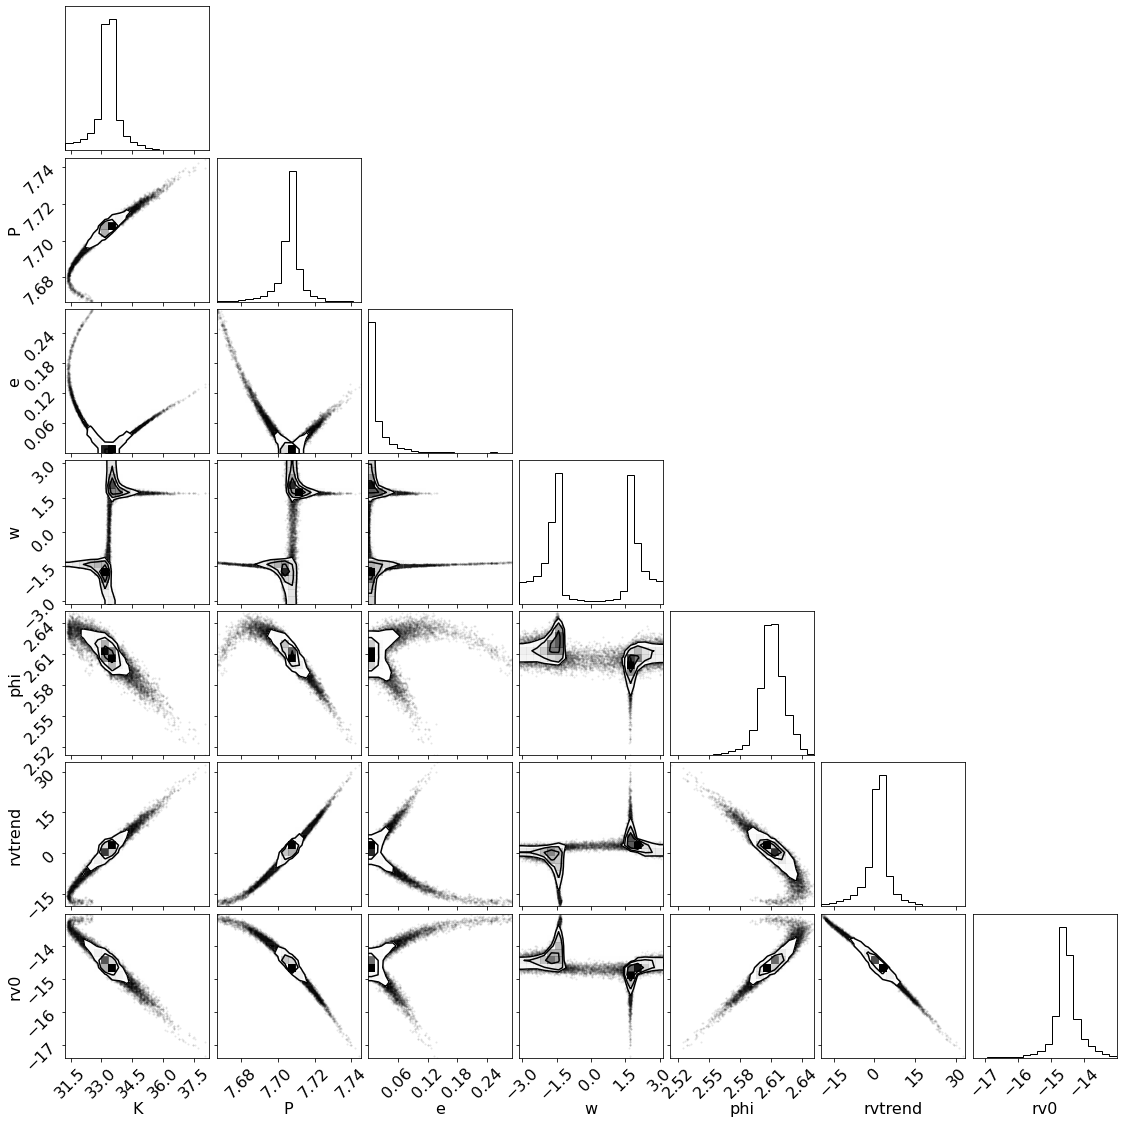

In [73]:
_ = corner(paramtrace, var_names=['K','P','e','w','phi','rvtrend','rv0'], divergences=True, plot_contours=True)

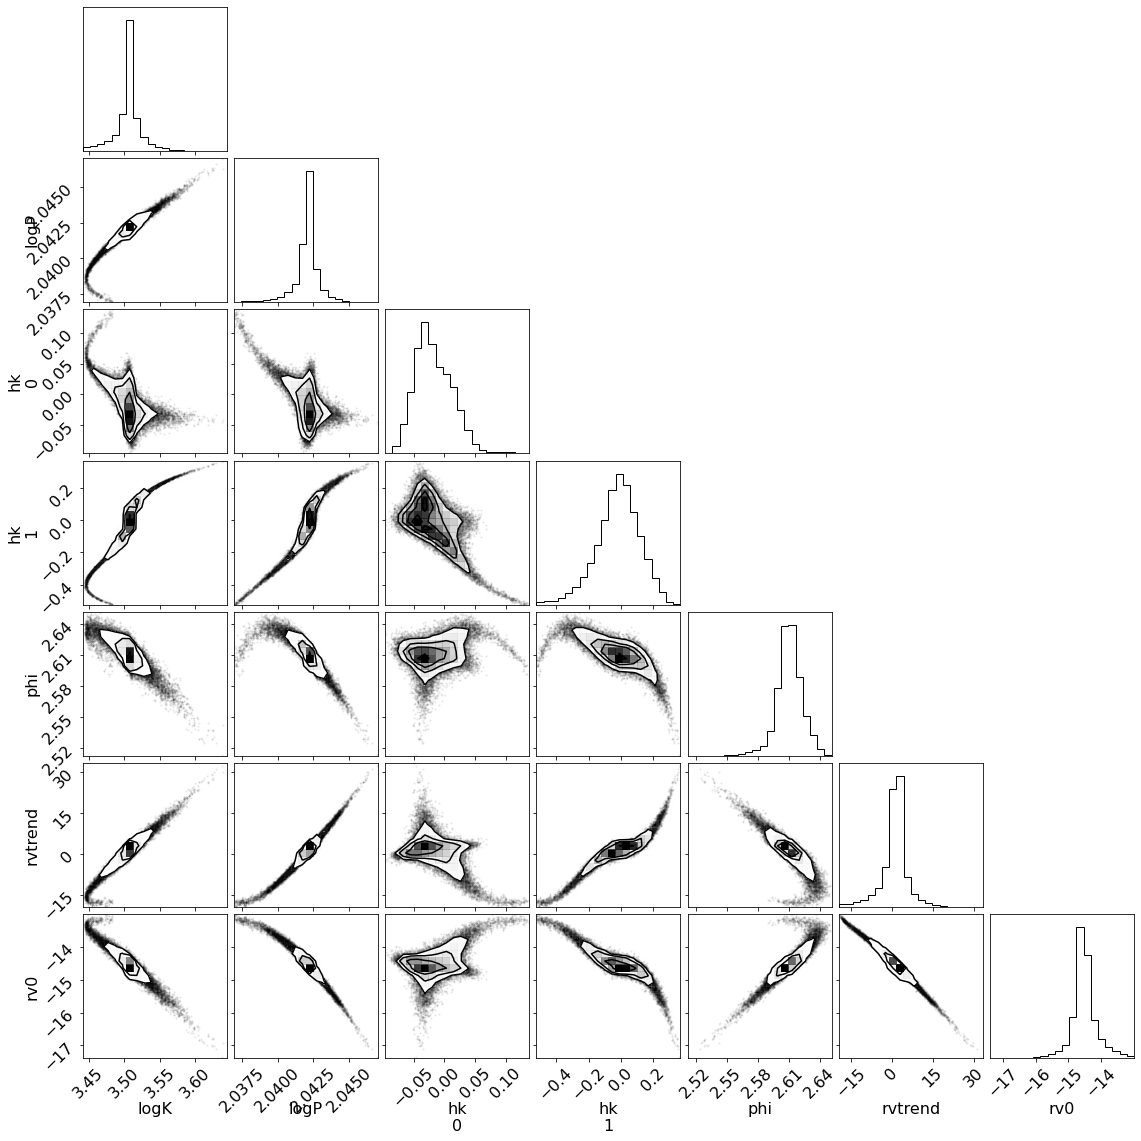

In [75]:
_ = corner(paramtrace, var_names=['logK','logP','hk','phi','rvtrend','rv0'], divergences=True, plot_contours=True)

[-43.35095068  18.35880141  17.59133911 -19.02656689 -29.07450821
 -24.81417288]


Text(0, 0.5, 'radial velocity')

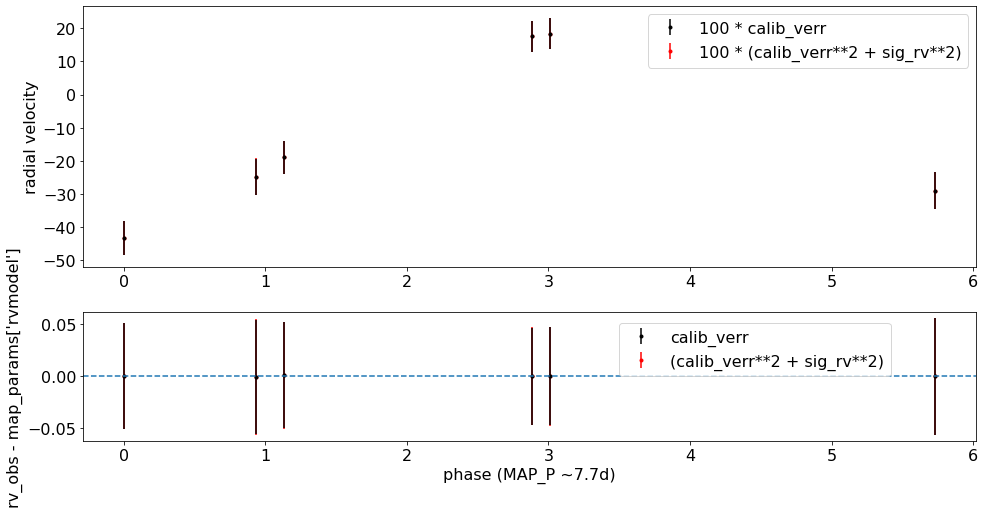

In [63]:
from matplotlib.gridspec import GridSpec
gs1 = GridSpec(nrows=50,ncols=1)
fig = plt.figure()
ax1 = fig.add_subplot(gs1[:30,:])
ax2 = fig.add_subplot(gs1[35:,:])

period = map_params['P']
rvphase = map_params['rvphase']
# sig_rv = map_params['log_sigma_rv']

ax1.errorbar(t%period, rv, yerr=rv_err*100, fmt=".k",zorder=1, label='100 * calib_verr')
sig_rv_aft_mcmc = np.sqrt(rv_err**2. + np.exp(2.*map_params['log_sigma_rv']))


ax1.errorbar(t%period, rv, yerr=sig_rv_aft_mcmc*100, fmt='.r',zorder=0, label='100 * (calib_verr**2 + sig_rv**2)')
print(map_params['rvmodel'])

residuals_aft_mcmc = rv-map_params['rvmodel']
# with model:
ax2.errorbar(t%period, residuals_aft_mcmc, yerr=rv_err, fmt='.k',zorder=1,label='calib_verr')
ax2.errorbar(t%period, residuals_aft_mcmc, yerr=sig_rv_aft_mcmc,fmt='.r',zorder=0, label='(calib_verr**2 + sig_rv**2)')
ax2.axhline(0,ls='--')

ax1.legend()
ax2.legend(fontsize=16,loc=(0.6,0.5))


rcParams['font.size'] = 16
ax2.set_xlabel("phase (MAP_P ~7.7d)")
ax2.set_ylabel("rv_obs - map_params['rvmodel']")
ax1.set_ylabel("radial velocity")

Text(0, 0.5, 'rv - rvmodel')

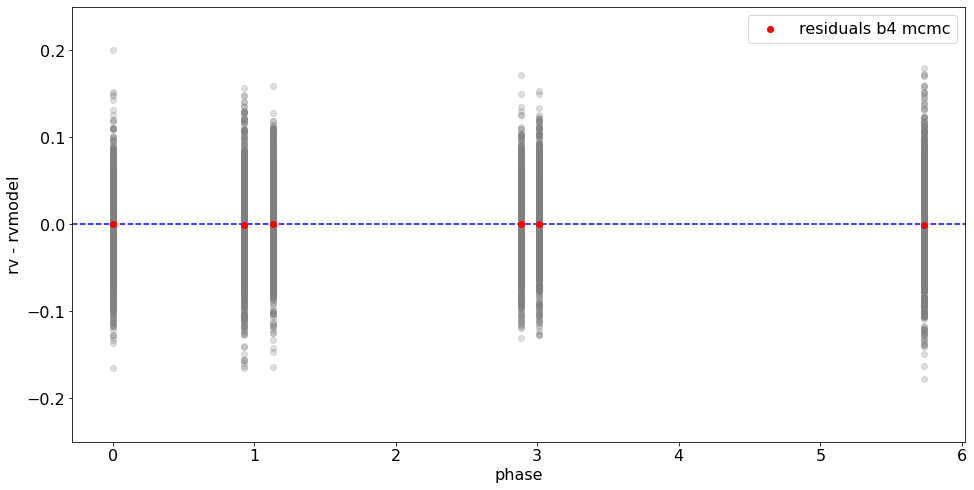

In [79]:
fig,ax = plt.subplots()

period = map_params['P']
ax.scatter(t%period, residuals_b4_mcmc, marker='o',c='red',label='residuals b4 mcmc',zorder=2)

rvmodel = paramtrace.posterior['rvmodel']
for ind in np.random.randint(np.prod(paramtrace.posterior['bkg'].shape[:2]),size=1024):
    i = np.unravel_index(ind, paramtrace.posterior['bkg'].shape[:2])
    ax.scatter(t%period, rv - rvmodel[i], c='gray', alpha=0.25,zorder=1)
ax.axhline(0.0, ls='--',c='blue',zorder=0)
ax.legend()
ax.set_ylim(-.25,.25)
ax.set_xlabel("phase")
ax.set_ylabel("rv - rvmodel")

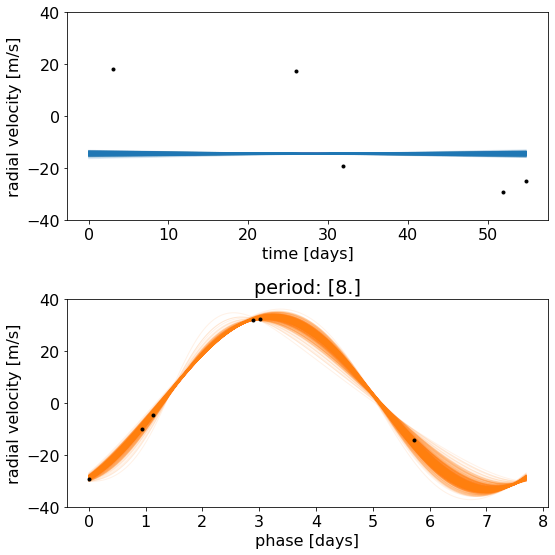

In [77]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

period = map_params["P"]

ax = axes[0]
ax.errorbar(t, rv, yerr=rv_err, fmt=".k")
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("time [days]")

ax = axes[1]
ax.errorbar(t % period, rv - map_params["bkg"], yerr=rv_err, fmt=".k")
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("phase [days]")

bkg = paramtrace.posterior["bkg"].values
rvphase = paramtrace.posterior["rvphase"].values
mcmc_per = paramtrace.posterior['logP'].values

for ind in np.random.randint(np.prod(bkg.shape[:2]), size=1024):
    i = np.unravel_index(ind, bkg.shape[:2])
    axes[0].plot(t, bkg[i], color="C0", lw=1, alpha=0.1)
    axes[1].plot(phase * period, rvphase[i], color="C1", lw=1, alpha=0.1)
    
axes[0].set_ylim(-40, 40)
axes[1].set_ylim(-40, 40)
axes[1].set_title(f'period: {np.round(period.flatten())}')
plt.tight_layout()

array([[<AxesSubplot:title={'center':'logP'}>,
        <AxesSubplot:title={'center':'logP'}>],
       [<AxesSubplot:title={'center':'rv0'}>,
        <AxesSubplot:title={'center':'rv0'}>],
       [<AxesSubplot:title={'center':'rvtrend'}>,
        <AxesSubplot:title={'center':'rvtrend'}>],
       [<AxesSubplot:title={'center':'log_sigma_rv'}>,
        <AxesSubplot:title={'center':'log_sigma_rv'}>],
       [<AxesSubplot:title={'center':'logK'}>,
        <AxesSubplot:title={'center':'logK'}>],
       [<AxesSubplot:title={'center':'phi'}>,
        <AxesSubplot:title={'center':'phi'}>],
       [<AxesSubplot:title={'center':'hk'}>,
        <AxesSubplot:title={'center':'hk'}>],
       [<AxesSubplot:title={'center':'e'}>,
        <AxesSubplot:title={'center':'e'}>],
       [<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'w'}>],
       [<AxesSubplot:title={'center':'P'}>,
        <AxesSubplot:title={'center':'P'}>],
       [<AxesSubplot:title={'center':'K'}>,
        <A

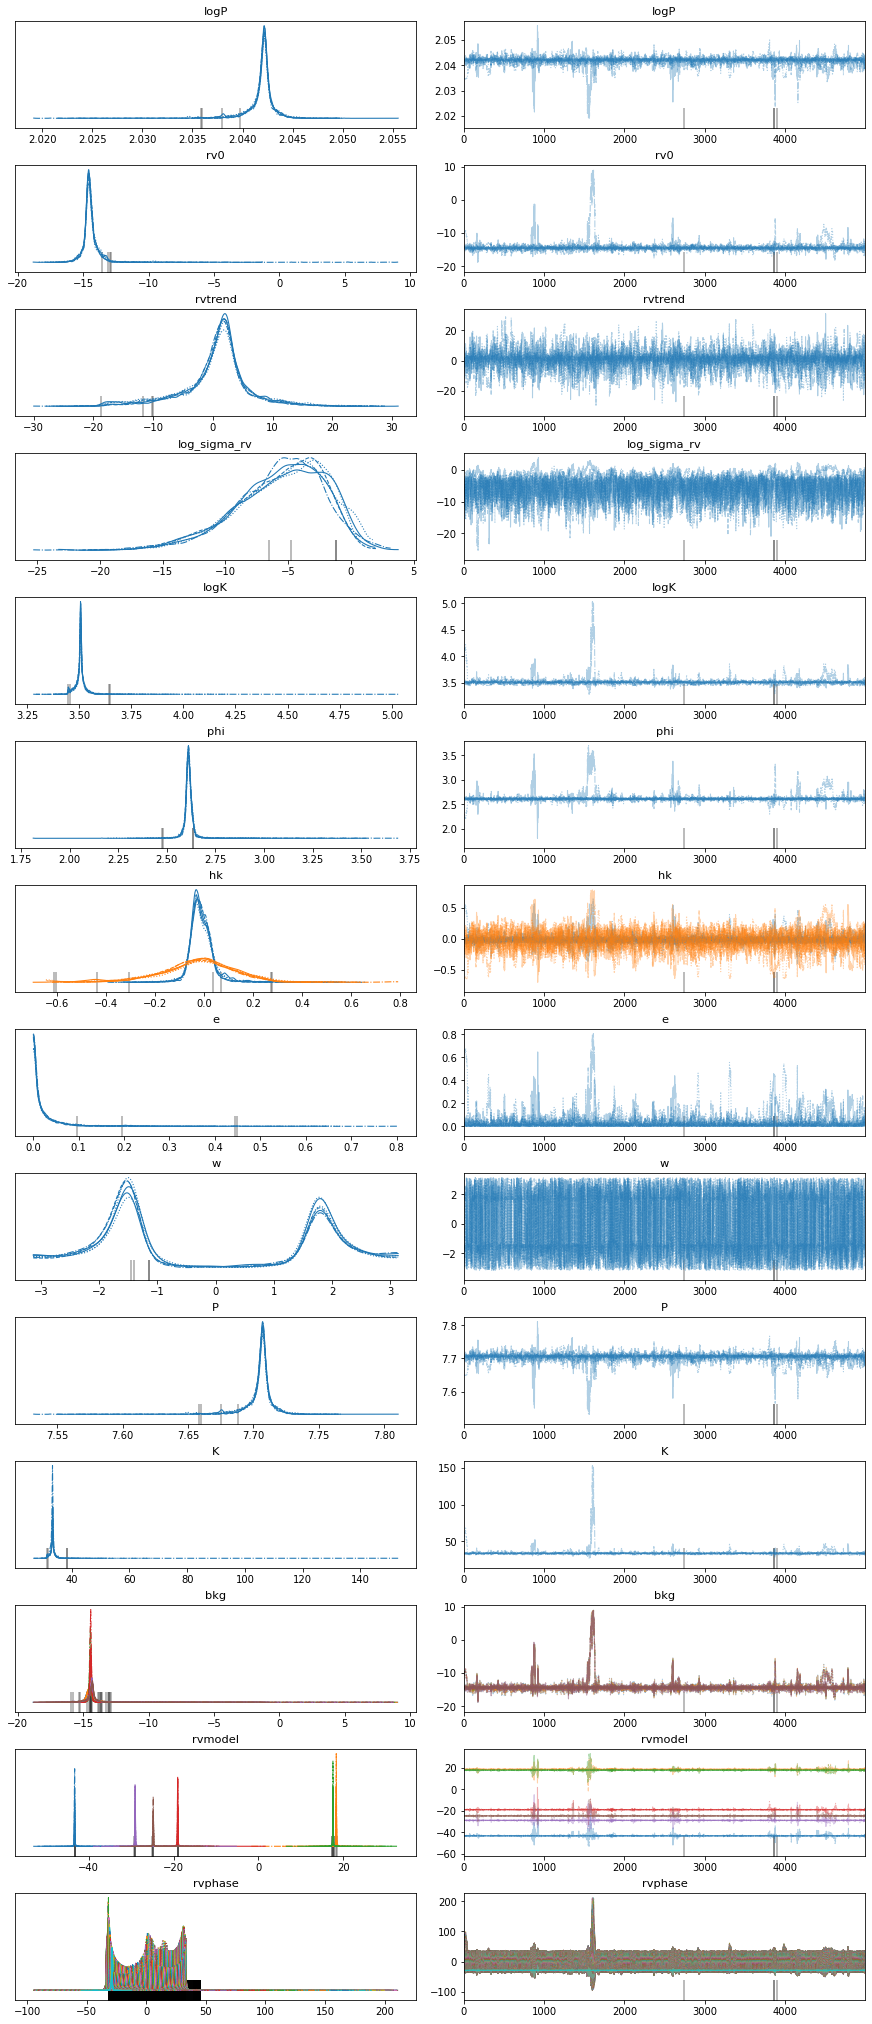

In [66]:
az.plot_trace(paramtrace)

# pymc3 RV model for TIC 20215452 (more RV measurements, might be SB2)

In [83]:
sysapodat2 = astab.Table.read(dd+"dr17_joker/tic20215452_apogee_visit_data.fits", hdu=1, format='fits')
sysapodat2 = astab.join(sysapodat2, calibverr, keys=['VISIT_ID','VISIT_ID'])

<ErrorbarContainer object of 3 artists>

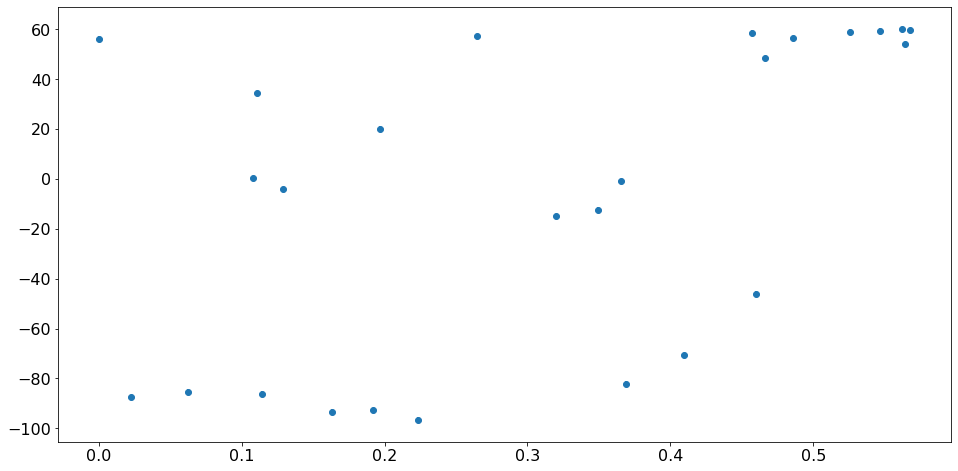

In [212]:
fig,ax = plt.subplots()
ax.errorbar((sysapodat2['JD']-sysapodat2['JD'].min())%0.59, sysapodat2['VHELIO'],yerr=sysapodat2['CALIB_VERR'],fmt='o')

In [223]:
MAP_P,MAP_P_err =0.37, _ 

rv = sysapodat2['VHELIO']
rv_err = sysapodat2['CALIB_VERR']
t = sysapodat2['JD'].astype("float")
t -= np.min(t)
x_ref = 0.5 * (x.min() + x.max())

# t = np.linspace(x.min()-1, x.max()+1, 1000)

# print(x.min(),x.max())
rv_amp = 0.5 * (np.max(rv) - np.min(rv))

with pm.Model() as model:

    # Parameters
    logK = pm.Uniform(
        "logK",
        lower=0,
        upper=5*np.log(rv_amp),
        testval=np.log(rv_amp),
    )
#     logK = pm.Normal(
#         "logK",
#         mu=np.log(rv_amp),
#         sd=5,
#         testval=np.log(rv_amp)
#     )


#     logP = pm.Normal(
#         "logP",mu=np.log(MAP_P), sd=5, testval=np.log(MAP_P) 
#      )
    logP = pm.Uniform(
            "logP", 
        lower=-3, 
        upper=1, 
        testval=np.log(MAP_P)
    )
    
#     logP = pm.Lognormal(
#         "logP",
#         mu=4.8,
#         sd=2.3,
#         testval = np.log(MAP_P)
#     )
    phi = pm.Uniform("phi", lower=0, upper=2 * np.pi, testval=0.1)
    
#     prephi = pmx.UnitUniform("prephi", testval=0.1)
#     phi = pm.Deterministic('phi', 2.*np.pi*prephi)
    
    
    # Parameterize the eccentricity using:
    #  h = sqrt(e) * sin(w)
    #  k = sqrt(e) * cos(w)
    hk = pmx.UnitDisk("hk", testval=np.array([0.01, 0.01]))
    e = pm.Deterministic("e", hk[0] ** 2 + hk[1] ** 2)
    w = pm.Deterministic("w", tt.arctan2(hk[1], hk[0]))

    rv0 = pm.Normal("rv0", mu=0.0, sd=10.0, testval=0.0)
    
    rvtrend = pm.Normal("rvtrend", mu=0.0, sd=10.0, testval=0.0)

    # Deterministic transformations
    n = 2 * np.pi * tt.exp(-logP)
    P = pm.Deterministic("P", tt.exp(logP))
    K = pm.Deterministic("K", tt.exp(logK))
    cosw = tt.cos(w)
    sinw = tt.sin(w)
    t0 = (phi + w) / n

    # The RV model
    bkg = pm.Deterministic("bkg", rv0 + rvtrend * t / 365.25)
    M = n * t - (phi + w)   #remove arg of peri + w)

    # This is the line that uses the custom Kepler solver
    f = xo.orbits.get_true_anomaly(M, e + tt.zeros_like(M))
    rvmodel = pm.Deterministic(
        "rvmodel", bkg + K * (cosw * (tt.cos(f) + e) - sinw * tt.sin(f))
    )

    
    ## adding in some wiggle room (e.g. jitter) on the RV measurements 
    log_sigma_rv = pm.Normal(
        "log_sigma_rv", mu=np.log(np.median(rv_err)), sd=5.
    )
    
    err = tt.sqrt(rv_err ** 2 + tt.exp(2 * log_sigma_rv))
    # Condition on the observations
    pm.Normal("obs", mu=rvmodel, sd=err, observed=rv)

    # Compute the phased RV signal
    phase = np.linspace(0, 1, 500)
    M_pred = 2 * np.pi * phase - (phi + w)
    f_pred = xo.orbits.get_true_anomaly(M_pred, e + tt.zeros_like(M_pred))
    rvphase = pm.Deterministic(
        "rvphase", K * (cosw * (tt.cos(f_pred) + e) - sinw * tt.sin(f_pred))
    )

In [224]:
with model:
#     map_params = pmx.optimize(vars=[logK])
    map_params = pmx.optimize(vars=[logK, rvtrend, rv0, hk, phi])
    map_params = pmx.optimize(start=map_params, vars=[logP])



optimizing logp for variables: [phi, hk, rv0, rvtrend, logK]


message: Desired error not necessarily achieved due to precision loss.
logp: -47576.53955557385 -> -25830.06267801917
optimizing logp for variables: [logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -25830.06267801917 -> -25708.946248501932


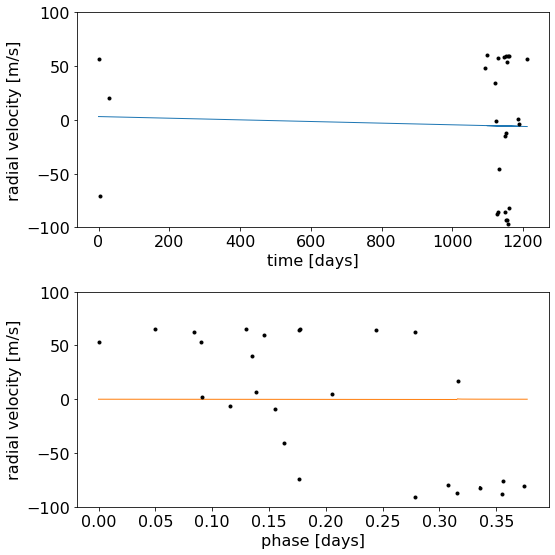

In [225]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

period = map_params["P"]

ax = axes[0]
ax.errorbar(t, rv, yerr=rv_err, fmt=".k")
ax.plot(t, map_params["bkg"], color="C0", lw=1)
ax.set_ylim(-100, 100)
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("time [days]")

ax = axes[1]
ax.errorbar(t % period, rv - map_params["bkg"], yerr=rv_err, fmt=".k")
ax.plot(phase * period, map_params["rvphase"], color="C1", lw=1)
ax.set_ylim(-100, 100)
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("phase [days]")

plt.tight_layout()

In [219]:
with model:
    paramtrace2 = pmx.sample(
        draws=2000,
        tune=5000,
        start=map_params,
        chains=4,
        cores=4,
        target_accept=0.99,
        return_inferencedata=True,
    )

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma_rv, rvtrend, rv0, hk, phi, logP, logK]
INFO:pymc3:NUTS: [log_sigma_rv, rvtrend, rv0, hk, phi, logP, logK]


Sampling 4 chains for 5_000 tune and 2_000 draw iterations (20_000 + 8_000 draws total) took 1455 seconds.
INFO:pymc3:Sampling 4 chains for 5_000 tune and 2_000 draw iterations (20_000 + 8_000 draws total) took 1455 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


In [220]:
az.summary(
    paramtrace2,
    var_names=['logK','rvtrend', 'rv0', 'hk', 'phi'],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
logK,4.178,0.538,2.964,4.735,0.150,0.113,10.0,32.0,1.64
rvtrend,-3.815,3.567,-10.974,2.193,1.290,0.950,8.0,63.0,1.46
rv0,-0.311,13.990,-19.600,21.218,6.352,4.793,5.0,29.0,2.04
hk[0],-0.159,0.349,-0.761,0.521,0.111,0.081,10.0,30.0,1.33
hk[1],-0.153,0.389,-0.975,0.372,0.163,0.122,7.0,28.0,1.55
phi,0.733,1.345,0.000,4.101,0.395,0.286,7.0,14.0,1.54


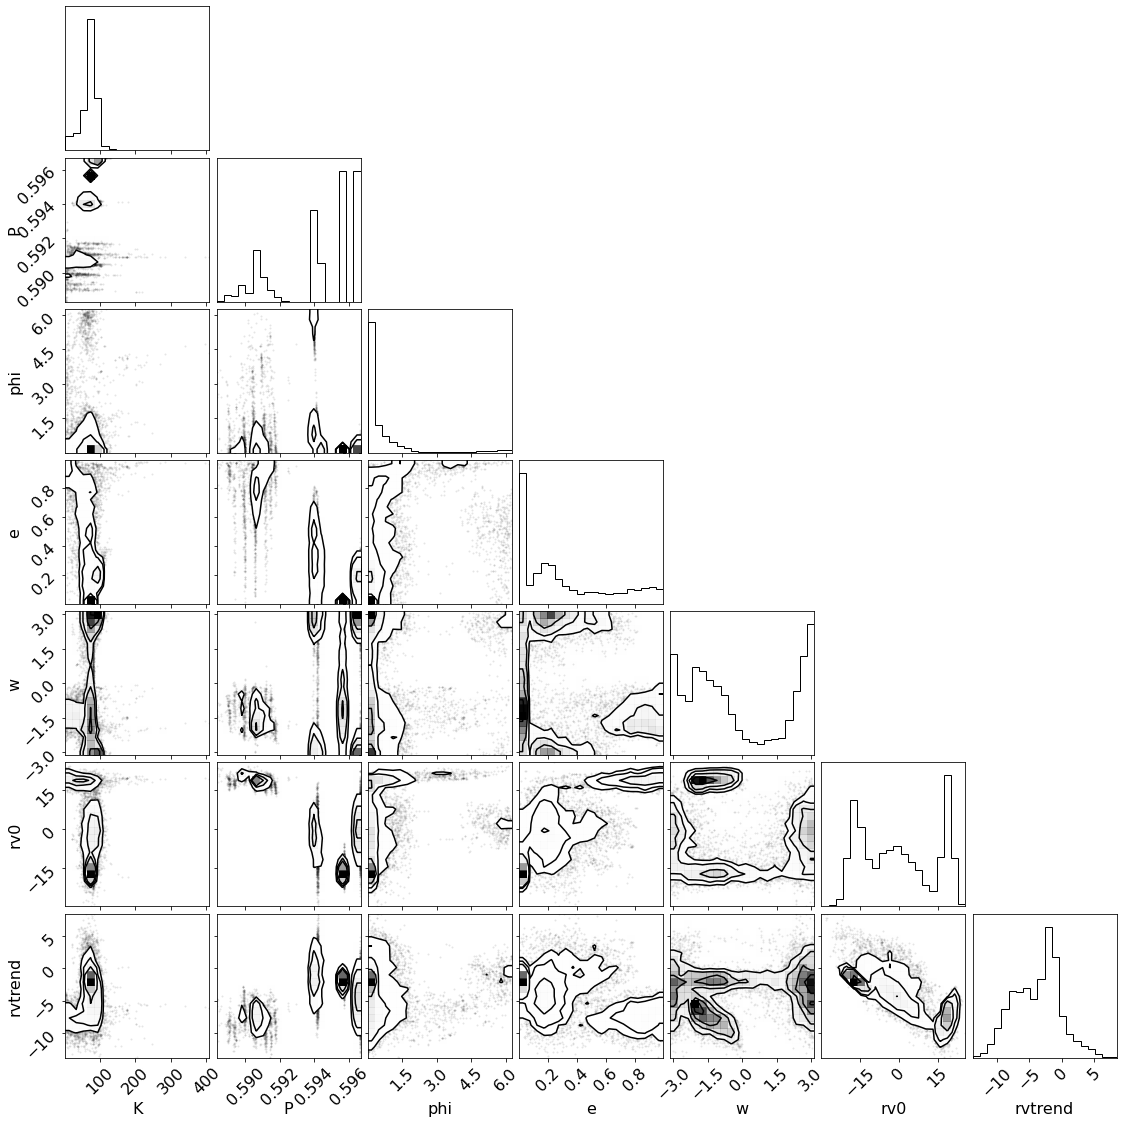

In [221]:
_ = corner(paramtrace2, var_names=["K", "P", "phi", "e", "w", "rv0", "rvtrend"])

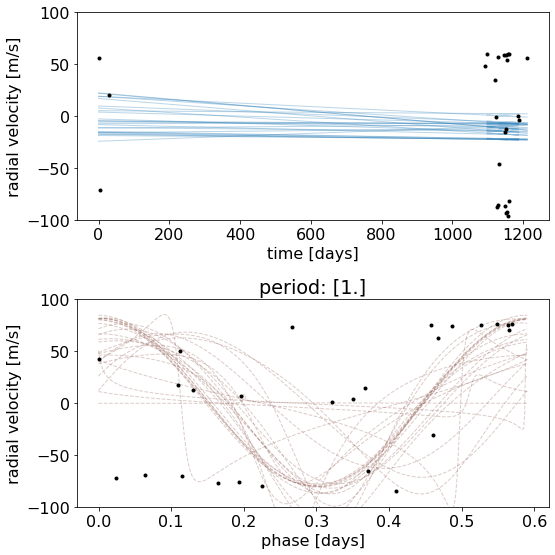

In [222]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

period = map_params["P"]

ax = axes[0]
ax.errorbar(t, rv, yerr=rv_err, fmt=".k")
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("time [days]")

ax = axes[1]
ax.errorbar(t % period, rv - map_params["bkg"], yerr=rv_err, fmt=".k")
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("phase [days]")

bkg = paramtrace2.posterior["bkg"].values
rvphase = paramtrace2.posterior["rvphase"].values
mcmc_per = paramtrace2.posterior['logP'].values

for ind in np.random.randint(np.prod(bkg.shape[:2]), size=25):
    i = np.unravel_index(ind, bkg.shape[:2])
    axes[0].plot(t, bkg[i], color="C0", lw=1, alpha=0.3)
#     axes[1].plot(phase * np.exp(mcmc_per[i]), rvphase[i], color="C1", lw=1, alpha=0.3)
    axes[1].plot(phase * period, rvphase[i], color="C5",ls='--', lw=1, alpha=0.3)
    
axes[0].set_ylim(-100, 100)
axes[1].set_ylim(-100, 100)
axes[1].set_title(f'period: {np.round(period.flatten())}')
plt.tight_layout()